In [8]:
#import pymc as pm
import json
import numpy as np
import os
import pandas as pd
import random
#import tensorflow_probability as tfp
#import tensorflow as tf
#tfd = tfp.distributions
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)



<h1> Loading Data </h1>



Data are unigram counts for each sample in the corpus.
tf-idf values were also used for performance comparison.

In [9]:
project_dir = '/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis'
data_dir = os.path.join(project_dir, 'Data')
model_dir = os.path.join(data_dir, 'bayesian_linear_classifier')

# load the custom tokenizer
os.chdir(data_dir)
with open('target_idx.json')as file:
    target_idx = json.loads(file.read())
idx_target = {target_idx[a]:a for a in target_idx.keys()}

os.chdir(data_dir)

with open('token_idx_map.json', 'r') as file:
    token_idx_map = json.load(file)
idx_token_map = {token_idx_map[a]:a for a in token_idx_map.keys()}

with open('frequency_data.npy', 'rb') as f:
    frequency_data = np.load(f)
with open('target_inds.npy', 'rb') as f:
    target_inds = np.load(f)
with open('k.npy', 'rb') as f:
    k = np.load(f)

full_dataset = pd.read_csv('masked_data_set.csv')
performance_stats = pd.read_csv('performance_stats.csv', header = 0, sep = ',', index_col = 0)

In [ ]:
xtrain_standard = np.divide(x_train, np.sum(x_train, axis =1, keepdims=True))
xtest_standard = np.divide(x_test, np.sum(x_test, axis = 1, keepdims=True))

In [ ]:
frequency_data.shape

In [ ]:
help(model.fit)

<h1> Easy Implementation </h1>

In [14]:
import seaborn as sns; sns.set()
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

In [ ]:
model = MultinomialNB()
model.fit(x_train, y_train)
preds = model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

With inverse categorical weights:

In [15]:
counts = np.unique(y_train, return_counts=True)[-1]
inverse_probs = 1/counts / sum(1/counts)

weighted_model = MultinomialNB(class_prior = inverse_probs)
weighted_model.fit(x_train, y_train)
preds = weighted_model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

NameError: name 'y_train' is not defined

In [ ]:
sorted_features = np.argsort(weighted_model.feature_log_prob_, axis=-1)
sorted_features = np.flip(sorted_features, axis=1)
[[idx_token_map[a] for a in b] for b in sorted_features]

In [ ]:
m = weighted_model.feature_log_prob_.min(axis=0, keepdims=True)
n = np.divide(weighted_model.feature_log_prob_, m)

In [ ]:
feature_df = pd.DataFrame(n, columns = [idx_token_map[a] for a in idx_token_map.keys()],
            index = [idx_target[a] for a in idx_target.keys()])

In [ ]:
sort = feature_df.sort_values(by='RU', axis = 1)

In [ ]:

fig = px.imshow(sort, aspect='auto', contrast_rescaling='minmax')#, text_auto=True)
fig.show()

In [ ]:
m = model.feature_log_prob_.min(axis=0, keepdims=True)
n = np.divide(model.feature_log_prob_, m)
sns.heatmap(n, yticklabels=target_idx.keys())

What does the above heatmap say about how individual tokens contribute to the probability of observing a NL target? It seems like Japanese and Chinese learners have more distinct vocabularies. Is this supported by one-vs.-all performance on the given targets?

Look at the head of this distributions for more informative features, noting tokens which contrast highly.

In the tails, notice the cleft where Russian, Japanese, Spanish and Arabic shift: the log probabilities become stronger in the Russian, and weaker in the other target groups. Doesn't this suggest that sparse tokens are more commonly used by Russian learners 

Shouldn't you try to run this with tf-idf weighted values, to see how frequency and essay length contribute to the model: $P(w_i \vert T)$? Russian essays are longer on average, containing more words (higher counts).

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
tfidf_model = Pipeline([('tfidf', TfidfTransformer()), ('MNNB', MultinomialNB())]).fit(x_train, y_train)
preds = tfidf_model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

In [ ]:
m = tfidf_model['MNNB'].feature_log_prob_.min(axis=0, keepdims=True)
n = np.divide(tfidf_model['MNNB'].feature_log_prob_, m)

feature_tfidf = pd.DataFrame(n, columns = [idx_token_map[a] for a in idx_token_map.keys()],
            index = [idx_target[a] for a in idx_target.keys()])

In [ ]:
sort = feature_tfidf.sort_values(by='AR', axis = 1)

In [ ]:
fig = px.imshow(sort, aspect='auto', contrast_rescaling='minmax')#, text_auto=True)
fig.show()

It appears that about fifty percent of the data needed for accuracy is available in the form of token frequencies. Below I run 10-fold cross-validation on the same 'k' splits as BERT, withholding the validation sets.

In [17]:
  # get train-val-test split indices
j = len(full_dataset['k'].unique())
ints = [a for a in range(j)]
splits = []
all_k_stats = []
for a in ints:
    split = {}
    test = a
    split['test'] = test
    val = a + 1 if a + 1 in ints else 0
    split['val'] = val
    train = ints.copy()
    train.remove(test)
    train.remove(val)
    split['train'] = train
    splits.append(split)
splits

[{'test': 0, 'val': 1, 'train': [2, 3, 4, 5, 6, 7, 8, 9]},
 {'test': 1, 'val': 2, 'train': [0, 3, 4, 5, 6, 7, 8, 9]},
 {'test': 2, 'val': 3, 'train': [0, 1, 4, 5, 6, 7, 8, 9]},
 {'test': 3, 'val': 4, 'train': [0, 1, 2, 5, 6, 7, 8, 9]},
 {'test': 4, 'val': 5, 'train': [0, 1, 2, 3, 6, 7, 8, 9]},
 {'test': 5, 'val': 6, 'train': [0, 1, 2, 3, 4, 7, 8, 9]},
 {'test': 6, 'val': 7, 'train': [0, 1, 2, 3, 4, 5, 8, 9]},
 {'test': 7, 'val': 8, 'train': [0, 1, 2, 3, 4, 5, 6, 9]},
 {'test': 8, 'val': 9, 'train': [0, 1, 2, 3, 4, 5, 6, 7]},
 {'test': 9, 'val': 0, 'train': [1, 2, 3, 4, 5, 6, 7, 8]}]

In [ ]:
def train_k_fold_MNB(frequency_data, target_inds, k, tf_idf = False, fit_prior = False, reweight = False):
    all_preds = {}
    for i in range(len(set(k))):
        split = splits[i]

        test_features = frequency_data[np.where(k == splits[i]['test']), :].squeeze(0)
        test_labels = target_inds[np.where(k == splits[i]['test'])] 

        train_features = frequency_data[np.where(np.isin(k, splits[0]['train'])), :].squeeze(0)
        train_labels = target_inds[np.where(np.isin(k, splits[0]['train']))]

        n_samples = train_features.shape[0]
        n_features = train_features.shape[1]
        
        if reweight:
            counts = np.unique(targets, return_counts=True)[-1]
            inverse_probs = 1/counts / sum(1/counts)
        
        if tf_idf:
            model = Pipeline([('tfidf', TfidfTransformer()), 
                              ('MNNB', MultinomialNB(fit_prior = fit_prior,
                                                    class_prior = inverse_probs if reweight else None))])
        else:
            model = MultinomialNB(fit_prior = fit_prior,
                                 class_prior = inverse_probs if reweight else None)
        model.fit(train_features, train_labels)
        preds = model.predict(test_features)

        f1 = f1_score(test_labels, preds, average = 'macro')
        
        model_name = 'Näive Bayes: tf-idf' if tf_idf else 'Näive Bayes'
        performance_stats.loc[model_name, str(i)] = f1
        all_preds[i] = preds
    
    return all_preds

In [ ]:
MNNB_preds = train_k_fold_MNB(frequency_data, target_inds, k, tf_idf = False)

In [ ]:
performance_stats

<h1> SVM </h1>

In [18]:
from sklearn import svm

In [ ]:
help(model)

In [ ]:
model = svm.SVC(kernel = 'poly', degree = 3, class_weight = 'balanced')
model.fit(x_train, y_train)
preds = model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

In [ ]:
model = svm.SVC(kernel = 'rbf', class_weight = 'balanced')
model.fit(x_train, y_train)

preds = model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

In [ ]:
model = svm.SVC(kernel = 'poly', degree = 2, class_weight = 'balanced')
model.fit(x_train, y_train)

preds = model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

In [ ]:
model = svm.SVC(kernel = 'linear', class_weight = 'balanced')
model.fit(x_train, y_train)

preds = model.predict(x_test)

mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

f1_score(y_test, preds, average="macro")

It looks like the linear kernel is the best. Keeping raw frequencies instead of tf-idf is probably more true to the project, since BERT will also have access to text length. Next, run 10-fold cross-validation on same 'k's as BERT: note that validation sets are witheld from training.

In [ ]:
def train_k_fold_SVM(frequency_data, 
                     target_inds, 
                     k, 
                     kernel = 'linear', 
                     class_weight = 'balanced', 
                     
                     tf_idf = False, 
                     fit_prior = False, 
                     reweight = False):
    all_preds = {}
    for i in range(len(set(k))):
        split = splits[i]

        test_features = frequency_data[np.where(k == splits[i]['test']), :].squeeze(0)
        test_labels = target_inds[np.where(k == splits[i]['test'])] 

        train_features = frequency_data[np.where(np.isin(k, splits[i]['train'])), :].squeeze(0)
        train_labels = target_inds[np.where(np.isin(k, splits[i]['train']))]

        n_samples = train_features.shape[0]
        n_features = train_features.shape[1]
        
        model = svm.SVC(kernel=kernel,
                                 class_weight = class_weight )
        model.fit(train_features, train_labels)
        preds = model.predict(test_features)

        f1 = f1_score(test_labels, preds, average = 'macro')
        
        model_name = 'Linear SVM: tf-idf' if tf_idf else 'Linear SVM'
        performance_stats.loc[model_name, str(i)] = f1
        all_preds[i] = preds
        
    print(performance_stats)
    return all_preds

In [78]:
target_inds[np.where(k == splits[3]['test'])] == full_dataset[full_dataset.k == 3]['Target'].apply(lambda x: target_idx[x])

12       True
17       True
49       True
58       True
71       True
         ... 
16492    True
16497    True
16508    True
16512    True
16519    True
Name: Target, Length: 1652, dtype: bool

In [80]:
target_inds == full_dataset['Target'].apply(lambda x: target_idx[x])

0        True
1        True
2        True
3        True
4        True
         ... 
16517    True
16518    True
16519    True
16520    True
16521    True
Name: Target, Length: 16522, dtype: bool

In [83]:
len(train_labels)

13218

In [88]:
splits[3]['train']

[0, 1, 2, 5, 6, 7, 8, 9]

In [92]:
train_labels = target_inds[np.where(np.isin(k, splits[i]['test']))]
train_labels == full_dataset[full_dataset.k == 3]['Target'].apply(lambda x: target_idx[x])
train_labels == SVM_k3_preds.T

,0,1,2,3,4,5,6,7,8,9,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651
SVM_pred,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,False,True


In [107]:
train_labels.shape

(13218,)

In [108]:
test_labels == full_dataset.query('k == 3')['Target'].apply(lambda x: target_idx[x])

12       True
17       True
49       True
58       True
71       True
         ... 
16492    True
16497    True
16508    True
16512    True
16519    True
Name: Target, Length: 1652, dtype: bool

In [99]:
labels1 = target_inds[np.where(np.isin(k, splits[3]['test']))]
labels2 = target_inds[np.where(k == splits[3]['test'])]


In [130]:
len(test_labels) == len(target_inds)

False

In [127]:
test_labels[np.where(target_inds == 1),:]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [103]:
test_labels

,test_labels
0,1
1,0
2,2
3,3
4,1
...,...
1647,5
1648,4
1649,5
1650,5


In [141]:
i = 3
kernel = 'linear'
class_weight = 'balanced'
tf_idf = False, 
fit_prior = False, 
reweight = False
#split = splits[i]

test_features = frequency_data[np.where(np.isin(k, splits[i]['test'])), :].squeeze(0)
test_labels = target_inds[np.where(np.isin(k, splits[i]['test']))] 

train_features = frequency_data[np.where(np.isin(k, splits[i]['train'])), :].squeeze(0)
train_labels = target_inds[np.where(np.isin(k, splits[i]['train']))]

n_samples = train_features.shape[0]
n_features = train_features.shape[1]

model = svm.SVC(kernel=kernel,
                         class_weight = class_weight )
model.fit(train_features, train_labels)
preds = model.predict(test_features)

f1 = f1_score(test_labels, preds, average = 'macro')

model_name = 'Linear SVM: tf-idf' if tf_idf else 'Linear SVM'
#performance_stats.loc[model_name, str(i)] = f1
#all_preds[i] = preds

In [157]:
with open('SVM_k3_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [158]:
!pwd

/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis/Data/bayesian_linear_classifier


In [145]:
sum(SVM_k3_preds['SVM_pred'] == test_labels) / len(test_labels)

0.6180387409200968

In [124]:
full_dataset.query('k == 3')['Target'].apply(lambda x: target_idx[x])

12       1
17       0
49       2
58       3
71       1
        ..
16492    5
16497    4
16508    5
16512    5
16519    1
Name: Target, Length: 1652, dtype: int64

In [125]:
target_inds[np.where(np.isin(k, splits[3]['test']))]

array([1, 0, 2, ..., 5, 5, 1])

In [26]:
SVM_k3_preds = pd.DataFrame(np.expand_dims(preds, axis =1), columns = ['SVM_pred'])
SVM_k3_preds.to_csv('SVM_ks_preds.csv')

In [48]:
test_labels = pd.DataFrame(np.expand_dims(test_labels, axis= 1), columns = ['test_labels'])
test_labels.to_csv('test_labels.csv')

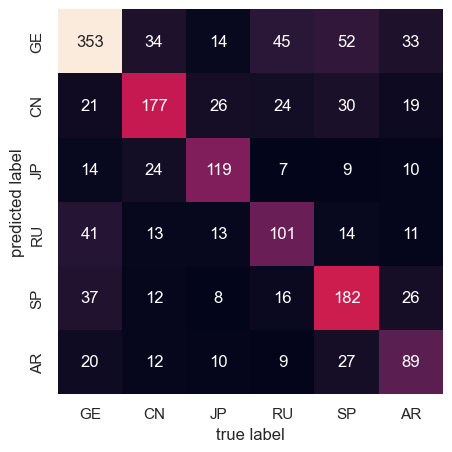

In [43]:
mat = confusion_matrix(test_labels, SVM_k3_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig("SVM_k3_confusion_matrix.png",
          dpi='figure', 
          format='png', 
          metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None
   )

In [131]:
f1

0.5964963337706496

In [37]:
plt.savefig('SVM_k3_confusion_matrix', format = 'png')

<Figure size 1000x500 with 0 Axes>

In [ ]:
svm_preds = train_k_fold_SVM(frequency_data, target_inds, k)

In [ ]:
svm_preds_1 = {a:list(svm_preds[a]) for a in svm_preds.keys()}

In [ ]:
BERT_fls = [0.6265133023262024,
 0.6104053258895874,
 0.6216707229614258,
 0.6053268909454346,
 0.5883777141571045,
 0.6180387139320374,
 0.6240919828414917,
 0.611985445022583,
 0.6200847029685974,
 0.5460048317909241]

In [ ]:
performance_stats.to_csv('performance_stats.csv')

In [ ]:
j = json.dumps(svm_preds_1)
with open('svm_preds.json', 'w') as f:
    f.write(j)

In [ ]:
help(json.dump)

In [ ]:
import plotly.express as px

In [ ]:
help(px.strip)

In [ ]:
performance_stats['mean'] = performance_stats.mean(axis=1)
performance_stats

In [ ]:
px.strip(performance_stats, 
         x = performance_stats.index, 
         y = performance_stats.columns,
         color = performance_stats.columns)

In [ ]:
performance_stats.round(3).to_csv('performance_stats.csv')

In [ ]:
performance_stats.round(3)

In [ ]:
!pwd

In [ ]:
performance_stats.iloc[:, 0:9].mean(axis=1)

In [ ]:
mean_dist = performance_stats.apply(lambda x: np.abs(performance_stats['mean'] - x))

In [ ]:
mean_dist.drop('mean', axis =1).idxmin(axis=1)

In [ ]:
help(mean_dist.min)

In [ ]:

performance_stats = pd.read_csv('performance_stats.csv')

In [ ]:
performance_stats.drop('9', axis = 1).mean(axis =1)